<a href="https://colab.research.google.com/github/khmelkoff/TraxRuSummarizer/blob/main/TraxRuSummarizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip -q install trax

     |████████████████████████████████| 522kB 23.2MB/s 
     |████████████████████████████████| 215kB 51.3MB/s 
     |████████████████████████████████| 3.4MB 51.6MB/s 
     |████████████████████████████████| 3.8MB 51.3MB/s 
     |████████████████████████████████| 1.2MB 51.5MB/s 
     |████████████████████████████████| 71kB 12.1MB/s 
     |████████████████████████████████| 1.8MB 49.9MB/s 
     |████████████████████████████████| 368kB 64.6MB/s 
     |████████████████████████████████| 890kB 50.5MB/s 
     |████████████████████████████████| 3.2MB 51.3MB/s 


In [2]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import random
# from unicodedata import normalize
# import sentencepiece as spm

import trax
from trax import layers as tl
from trax.supervised import decoding

%matplotlib inline

In [3]:
import textwrap
wrapper = textwrap.TextWrapper(width=70)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Load the data

In [ ]:
# data = pd.read_csv('/content/drive/MyDrive/lenta-ru-news.csv.zip')
# data.head()

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,url,title,text,topic,tags,date
0,https://lenta.ru/news/1914/09/16/hungarnn/,1914. Русские войска вступили в пределы Венгрии,Бои у Сопоцкина и Друскеник закончились отступ...,Библиотека,Первая мировая,1914/09/16
1,https://lenta.ru/news/1914/09/16/lermontov/,1914. Празднование столетия М.Ю. Лермонтова от...,"Министерство народного просвещения, в виду про...",Библиотека,Первая мировая,1914/09/16
2,https://lenta.ru/news/1914/09/17/nesteroff/,1914. Das ist Nesteroff!,"Штабс-капитан П. Н. Нестеров на днях, увидев в...",Библиотека,Первая мировая,1914/09/17
3,https://lenta.ru/news/1914/09/17/bulldogn/,1914. Бульдог-гонец под Льежем,Фотограф-корреспондент Daily Mirror рассказыва...,Библиотека,Первая мировая,1914/09/17
4,https://lenta.ru/news/1914/09/18/zver/,1914. Под Люблином пойман швабский зверь,"Лица, приехавшие в Варшаву из Люблина, передаю...",Библиотека,Первая мировая,1914/09/18


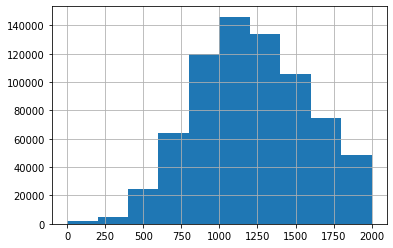

In [ ]:
# data['text_len'] = [len(x) if not type(x)==float else 0 for x in data.text]
# data.text_len[data.text_len < 2000].hist()

In [ ]:
# text_full = []  # full text list for train senttence piece tokenizer
# text_pairs = [] # paired data for train the model, format: (title, text)
# for i in tqdm(range(data.shape[0])):
    # if data.iloc[i, 6] >= 200 and data.iloc[i, 6] <= 2000:
        # text_full.append(data.iloc[i, 1].lower() + '\n' + data.iloc[i, 2].lower())
        # list of (article, summary)
        # text_pairs.append((data.iloc[i, 2].lower(), data.iloc[i, 1].lower()))

# save full text to text file        
# with open('full_text.txt', 'w', encoding='utf-8') as file:
#     file.write('\n'.join(text_full))  

100%|██████████| 800975/800975 [01:05<00:00, 12189.45it/s]


In [ ]:
# text_pairs[0]

('бои у сопоцкина и друскеник закончились отступлением германцев. неприятель, приблизившись с севера к осовцу начал артиллерийскую борьбу с крепостью. в артиллерийском бою принимают участие тяжелые калибры. с раннего утра 14 сентября огонь достиг значительного напряжения. попытка германской пехоты пробиться ближе к крепости отражена. в галиции мы заняли дембицу. большая колонна, отступавшая по шоссе от перемышля к саноку, обстреливалась с высот нашей батареей и бежала, бросив парки, обоз и автомобили. вылазки гарнизона перемышля остаются безуспешными. при продолжающемся отступлении австрийцев обнаруживается полное перемешивание их частей, захватываются новые партии пленных, орудия и прочая материальная часть. на перевале ужок мы разбили неприятельский отряд, взяли его артиллерию и много пленных и, продолжая преследовать, вступили в пределы венгрии. \n«русский инвалид», 16 сентября 1914 года.',
 '1914. русские войска вступили в\xa0пределы венгрии  ')

## Load / Train BPE tokenizer

In [ ]:
# train tokenizer
# spm.SentencePieceTrainer.train('--input=full_text.txt --pad_id=0 --bos_id=-1 --eos_id=1 --unk_id=2 \
#                                --model_prefix=bpe --vocab_size=32000 --model_type=bpe')
# sp = spm.SentencePieceProcessor()
# sp.load('/content/drive/MyDrive/bpe.model')

In [ ]:
# s0 = text_pairs[10][0]
# text_list = wrapper.wrap(s0[:300])
# for line in text_list:
#     print(line)

сегодня областной центр сахалина и курил получил статус очага
распространения холеры. как сообщает итар-тасс со ссылкой на пресс-
центр администрации сахалинской области, в лечебных учреждениях южно-
сахалинска уже находятсятся 5 горожан, причем у двоих из них болезнь
проходит в средне-тяжелой форме.


In [ ]:
# # tokenizer check
# print('encode: text => id:')
# print(sp.encode_as_pieces(s0[:300]))
# print('')
# print(sp.encode_as_ids(s0[:300]))
# print('')
# print('decode: id => text:')
# print(sp.decode_pieces(sp.encode_as_pieces(s0[:300])))
# print('')
# print(f'Beginning of sentence id: {sp.bos_id()}')
# print(f'Pad id: {sp.pad_id()}')
# print(f'End of sentence id: {sp.eos_id()}')
# print(f'Unknown id: {sp.unk_id()}')
# print(f'Vocab size: {sp.vocab_size()}')      

In [ ]:
# uid = 18298
# spiece = "\u2581Саха"
# unknown = "_НЕИЗВЕСТНОСТЬ_"

# # id <=> piece conversion
# print(f'SentencePiece for ID {uid}: {sp.id_to_piece(uid)}')
# print(f'ID for Sentence Piece {spiece}: {sp.piece_to_id(spiece)}')

# # returns 0 for unknown tokens (we can change the id for UNK)
# print(f'ID for unknown text {unknown}: {sp.piece_to_id(unknown)}')

In [ ]:
# # vocab's head and tail test
# print('\nId\tSentP\tControl?')
# print('------------------------')
# for uid in range(7):
#     print(uid, sp.id_to_piece(uid), sp.is_control(uid), sep='\t')
    
# for uid in range(sp.vocab_size()-7,sp.vocab_size()):
#     print(uid, sp.id_to_piece(uid), sp.is_control(uid), sep='\t')

## Data: preprocess and create generators

In [5]:
text_pairs = pd.read_csv('/content/drive/MyDrive/lenta.csv', sep=';')
text_pairs = [(x, y) for x, y in zip(text_pairs.article, text_pairs.summary)]
print(wrapper.fill(text_pairs[0][0]))
print(wrapper.fill(text_pairs[0][1]))

проведение нового раунда минских переговоров по ситуации на украине в
ближайшее время исключено. об этом, как сообщает тасс, заявил советник
главы службы безопасности украины (сбу) маркиян лубкивский. «минска-2
не будет. у нас есть минск-1 и те договоренности, которые нужно
выполнять», — сказал лубкивский в эфире телеканала "1+1", обвинив
ополченцев в нарушении прежних договоренностей. в четверг полномочный
представитель самопровозглашенной донецкой народной республики (днр)
на переговорах контактной группы в минске денис пушилин заявил, что
власти республики готовы к возобновлению минского процесса. при этом
он выразил недоумение относительно позиции киева, который, по его
мнению, «стремится к полному прекращению минского процесса, чтобы
отказаться от прямых контактов с республиками». в сентябре 2014 года в
минске состоялись две встречи контактной группы по украине. 20
сентября был принят меморандум по осуществлению режима прекращения
огня, состоящий из девяти пунктов. 5 сентября был 

In [6]:
# train/eval split
margin = int(len(text_pairs)*0.95)
train_text_pairs = text_pairs[:margin]
print('train cases: ', len(train_text_pairs))
eval_text_pairs = text_pairs[margin:]
print('eval cases: ', len(eval_text_pairs))

train cases:  686277
eval cases:  36120


In [7]:
print(wrapper.fill(train_text_pairs[0][0]))

проведение нового раунда минских переговоров по ситуации на украине в
ближайшее время исключено. об этом, как сообщает тасс, заявил советник
главы службы безопасности украины (сбу) маркиян лубкивский. «минска-2
не будет. у нас есть минск-1 и те договоренности, которые нужно
выполнять», — сказал лубкивский в эфире телеканала "1+1", обвинив
ополченцев в нарушении прежних договоренностей. в четверг полномочный
представитель самопровозглашенной донецкой народной республики (днр)
на переговорах контактной группы в минске денис пушилин заявил, что
власти республики готовы к возобновлению минского процесса. при этом
он выразил недоумение относительно позиции киева, который, по его
мнению, «стремится к полному прекращению минского процесса, чтобы
отказаться от прямых контактов с республиками». в сентябре 2014 года в
минске состоялись две встречи контактной группы по украине. 20
сентября был принят меморандум по осуществлению режима прекращения
огня, состоящий из девяти пунктов. 5 сентября был 

In [8]:
def data_generator(data, shuffle=True):
    '''
      Input: 
        data - list containing tuples (article, summary)
        shuffle - If True: shuffle the data order
      Output:
        a tuple containing 2 elements:
        article
        summary
    '''
    
    data_lng = len(data) # len(data)
    index_list = [*range(data_lng)] # Create a list with the ordered indexes of sample data

    if shuffle:
        random.shuffle(index_list) # re-shuffle the order
    
    index = 0 # Start with the first element
    while True:
        # Wrap the index each time that we reach the end of the list
        if index >= data_lng:
            index = 0
            if shuffle:
                random.shuffle(index_list) # re-shuffle the order
            
        sample = data[index_list[index]]
        index += 1
        yield(sample)

# create data streams
def train_data_stream():
    return data_generator(train_text_pairs, shuffle=True)

def eval_data_stream():
    return data_generator(eval_text_pairs, shuffle=True)        

In [9]:
PAD, EOS, UNK = 0, 1, 2

def detokenize(integers):
    s = trax.data.detokenize(
        integers,
        vocab_type='sentencepiece',
        vocab_file='bpe.model',
        vocab_dir='/content/drive/MyDrive/')
    return wrapper.fill(s)


def tokenize(s):
    inputs =  next(trax.data.tokenize(
        iter([s]),
        vocab_type='sentencepiece',
        vocab_file='bpe.model',
        vocab_dir='/content/drive/MyDrive/'))
    
    return list(inputs) + [EOS]
 
    
vocab_size = trax.data.vocab_size(
    vocab_type='sentencepiece',
    vocab_file='bpe.model',
    vocab_dir='/content/drive/MyDrive/')

print('vocab size: ', vocab_size)

vocab size:  16000


In [10]:
tokenize('тест')

[15117, 1]

In [11]:
tokenize('НЕИЗВЕСТНОСТЬ')

[15924, 2, 1]

In [ ]:
# tokenized = tokenize('сведения о пассажирах на всех видах транспорта, где используются именные проездные билеты')
# print('tokenized:')
# print(tokenized)
# print('len=', len(tokenized))
# detokenized = detokenize(tokenized)
# print('detokenized:')
# print(detokenized)
# print('len=', len(detokenized.split()))

In [12]:
# Concatenate tokenized inputs and targets using 0 as separator.
def preprocess(stream):
    for (article, summary) in stream:
        joint = np.array(list(article) + [EOS, PAD] + list(summary) + [EOS])
        mask = [0] * (len(list(article)) + 2) + [1] * (len(list(summary)) + 1) 
        yield joint, joint, np.array(mask)

# You can combine a few data preprocessing steps into a pipeline like this.
input_pipeline = trax.data.Serial(
    # Tokenizes
    trax.data.Tokenize(vocab_type='sentencepiece',
                       vocab_dir='/content/drive/MyDrive/',
                       vocab_file='bpe.model'),
    # Uses function defined above
    preprocess,
    trax.data.FilterByLength(2048)
)

# Apply preprocessing to data streams.
train_stream = input_pipeline(train_data_stream())
eval_stream = input_pipeline(eval_data_stream())

In [13]:
train_input, train_target, train_mask = next(train_stream)
# assert sum((train_input - train_target)**2) == 0  # They are the same in Language Model (LM).
# check pad (id:0) and sep/eos (id:1)
print(train_input[-20:])

[ 4563 15941  1068  1621   193   122   269 15949     1     0  6136  1328
 12205  4563 15941   861     5  1759  4652     1]


## Batching and Bucketing 

In [14]:
# batch of 8 sentences of length < 256 , 4 of length < 512....
boundaries =  [256, 512, 1024]
batch_sizes = [16, 8, 4, 2]

# Create the streams.
train_batch_stream = trax.data.BucketByLength(
    boundaries, batch_sizes)(train_stream)

eval_batch_stream = trax.data.BucketByLength(
    boundaries, batch_sizes)(eval_stream)

In [15]:
input_batch, _, mask_batch = next(train_batch_stream)

# Shape of the input_batch
input_batch.shape

(8, 512)

In [16]:
# check autopadding endig of sample
# 1, 0, <not 0 digit>... - end of article and start of summary
input_batch[0]

array([  620,  3389,  6958,  1995,  3481,  5184,  5481,   110, 10774,
          36,   291,   110,   221,    54,    38, 15933, 11819,   291,
         110, 15939,   482, 15972,    16,   110, 15956,   743, 15930,
         240,  4008, 15972, 11121,   303,     5,  3704,  9465,  1621,
          26,    62, 15945,  5138, 13002,  6498,  7263,  2103, 15949,
          63,   226,  6744,   110,  7066,   369,  1006,   371,  7424,
        8161,  7996,  4366,  1017,  4151,    11,    36,    33,    96,
       15949,  3771,   381,  3855, 10760,    43,  2668,  2478,    46,
         692,    96,   161,    70,  1872,  8266, 15949,   586,  3786,
          61,  1506, 12184,   136, 15996,   110, 15925,    36,    33,
       15948, 15945, 13372, 15946,  7644,  5322,   270,   291,   110,
       10435,  9475, 15956,   286, 15930,    82,    53, 15345, 15945,
          41, 13563, 14269,    59, 15936,  1255,  1519,   291,   110,
         795,    26,  5689,   210,    57,   882,   159,  3229,   249,
          11,    36,

## Transformer Model

### Positional encoder

In [17]:
def PositionalEncoder(vocab_size, d_model, dropout, max_len, mode):
    """Returns a list of layers that: 
    1. takes a block of text as input, 
    2. embeds the words in that text, and 
    3. adds positional encoding, 
       i.e. associates a number in range(max_len) with 
       each word in each sentence of embedded input text 
    
    The input is a list of tokenized blocks of text
    
    Args:
        vocab_size (int): vocab size.
        d_model (int):  depth of embedding.
        dropout (float): dropout rate (how much to drop out).
        max_len (int): maximum symbol length for positional encoding.
        mode (str): 'train' or 'eval'.
    """
    # Embedding inputs and positional encoder
    return [ 
        # Add embedding layer of dimension (vocab_size, d_model)
        tl.Embedding(vocab_size, d_model),  
        # Use dropout with rate and mode specified
        tl.Dropout(rate=dropout, mode=mode), 
        # Add positional encoding layer with maximum input length and mode specified
        tl.PositionalEncoding(max_len=max_len, mode=mode)] 

### Feed-Forward layer

In [18]:
def FeedForward(d_model, d_ff, dropout, mode, ff_activation):
    """Returns a list of layers that implements a feed-forward block.

    The input is an activation tensor.

    Args:
        d_model (int):  depth of embedding.
        d_ff (int): depth of feed-forward layer.
        dropout (float): dropout rate (how much to drop out).
        mode (str): 'train' or 'eval'.
        ff_activation (function): the non-linearity in feed-forward layer.

    Returns:
        list: list of trax.layers.combinators.Serial that maps an activation tensor to an activation tensor.
    """
    
    # Feed-forward block (list) with two dense layers with dropout and input normalized
    return [ 
        # Normalize layer inputs
        tl.LayerNorm(), 
        # Add first feed forward (dense) layer
        tl.Dense(d_ff), 
        # Add activation function passed in as a parameter
        ff_activation(),  # ReLU
        # Add dropout with rate and mode specified (don't use dropout during evaluation)
        tl.Dropout(rate=dropout, mode=mode), 
        # Add second feed forward layer
        tl.Dense(d_model), 
        # Add dropout with rate and mode specified
        tl.Dropout(rate=dropout, mode=mode) 
    ]

### Decoder Block

In [19]:
def DecoderBlock(d_model, d_ff, n_heads,
                 dropout, mode, ff_activation):
    """Returns a list of layers that implements a Transformer decoder block.

    The input is an activation tensor.

    Args:
        d_model (int):  depth of embedding.
        d_ff (int): depth of feed-forward layer.
        n_heads (int): number of attention heads.
        dropout (float): dropout rate (how much to drop out).
        mode (str): 'train' or 'eval'.
        ff_activation (function): the non-linearity in feed-forward layer.

    Returns:
        list: list of trax.layers.combinators.Serial that maps an activation tensor to an activation tensor.
    """
        
    # List of two Residual blocks: the attention with normalization and dropout and feed-forward blocks
    return [
      tl.Residual(
          # Normalize layer input
          tl.LayerNorm(), 
          # Add causal attention 
          tl.CausalAttention(d_model, n_heads=n_heads, dropout=dropout, mode=mode) 
        ),
      tl.Residual(
          # Add feed-forward block
          # The feed-forward block takes care of normalization
          FeedForward(d_model, d_ff, dropout, mode, ff_activation)
        ),
      ]

### Trnsformer (decoder)

In [20]:
def SumTransformer(vocab_size=vocab_size,
                  d_model=512,
                  d_ff=2048,
                  n_layers=6,
                  n_heads=8,
                  dropout=0.1,
                  max_len=4096,
                  mode='train',
                  ff_activation=tl.Relu):
    """Returns a Transformer language model.

    The input to the model is a tensor of tokens. (This model uses only the
    decoder part of the overall Transformer.)

    Args:
        vocab_size (int): vocab size.
        d_model (int):  depth of embedding.
        d_ff (int): depth of feed-forward layer.
        n_layers (int): number of decoder layers.
        n_heads (int): number of attention heads.
        dropout (float): dropout rate (how much to drop out).
        max_len (int): maximum symbol length for positional encoding.
        mode (str): 'train', 'eval' or 'predict', predict mode is for fast inference.
        ff_activation (function): the non-linearity in feed-forward layer.

    Returns:
        trax.layers.combinators.Serial: A Transformer language model as a layer that maps from a tensor of tokens
        to activations over a vocab set.
    """
    
    # Stack of decoder blocks with n_layers with necessary parameters
    decoder_blocks = [ 
        DecoderBlock(d_model, d_ff, n_heads, dropout, mode, ff_activation) for _ in range(n_layers)] 

    # The complete model
    return tl.Serial(
        # Use teacher forcing (feed output of previous step to current step)
        tl.ShiftRight(mode=mode), 
        # Add embedding inputs and positional encoder
        PositionalEncoder(vocab_size, d_model, dropout, max_len, mode),
        # Add decoder blocks
        decoder_blocks, 
        # Normalize layer
        tl.LayerNorm(), 

        # Add dense layer of vocab_size (since need to select a word to translate to)
        # (a.k.a., logits layer. Note: activation already set by ff_activation)
        tl.Dense(vocab_size), 
        # Get probabilities with Logsoftmax
        tl.LogSoftmax() 
    )

In [21]:
print(SumTransformer(n_layers=1))

Serial[
  Serial[
    ShiftRight(1)
  ]
  Embedding_16000_512
  Dropout
  PositionalEncoding
  Serial[
    Branch_out2[
      None
      Serial[
        LayerNorm
        Serial[
          Serial[
            Serial[
              Branch_out3[
                [Dense_512, Serial[
                  SplitIntoHeads
                ]]
                [Dense_512, Serial[
                  SplitIntoHeads
                ]]
                [Dense_512, Serial[
                  SplitIntoHeads
                ]]
              ]
              DotProductCausalAttention_in3
              Serial[
                MergeHeads
              ]
              Dense_512
            ]
          ]
        ]
      ]
    ]
    Add_in2
  ]
  Serial[
    Branch_out2[
      None
      Serial[
        LayerNorm
        Dense_2048
        Serial[
          Relu
        ]
        Dropout
        Dense_512
        Dropout
      ]
    ]
    Add_in2
  ]
  LayerNorm
  Dense_16000
  LogSoftmax
]


## Training

In [22]:
from trax.supervised import training

def training_loop(SumTransformer, train_gen, eval_gen, output_dir = "~/model"):
    '''
    Input:
        SumTransformer (trax.layers.combinators.Serial): The transformer model.
        train_gen (generator): Training stream of data.
        eval_gen (generator): Evaluation stream of data.
        output_dir (str): folder to save your file.
        
    Returns:
        trax.supervised.training.Loop: Training loop.
    '''
    output_dir = os.path.expanduser(output_dir)  # trainer is an object

    # for initial train
    # lr_schedule = trax.lr.warmup(n_warmup_steps=4000, max_value=0.00015)
    # lr_schedule = trax.lr.warmup_and_rsqrt_decay(n_warmup_steps=8000, max_value=0.00015)
    
    # for re-train
    lr_schedule = trax.supervised.lr_schedules.constant(0.0001)

    train_task = training.TrainTask( 
      labeled_data=train_gen, # The training generator
      loss_layer=tl.CrossEntropyLoss(), # Loss function 
      optimizer=trax.optimizers.Adam(0.0001), # Optimizer 
      lr_schedule=lr_schedule,
      n_steps_per_checkpoint=100
    )

    eval_task = training.EvalTask( 
      labeled_data=eval_gen, 
      metrics=[tl.CrossEntropyLoss(), tl.Accuracy()] 
    )

    loop = training.Loop(SumTransformer(d_model=512,
                                       d_ff=2048,
                                       n_layers=6,
                                       n_heads=8,
                                       mode='train'),
                         train_task,
                         eval_tasks=[eval_task],
                         output_dir=output_dir)
    
    return loop

In [23]:
!cp /content/drive/MyDrive/model/model.pkl.gz ~/model/

In [24]:
# Should take around 1 minute per 100 step on GPU
# !rm -f ~/model/model.pkl.gz
loop = training_loop(SumTransformer, train_batch_stream, eval_batch_stream)
loop.run(20000)
!cp ~/model/model.pkl.gz /content/drive/MyDrive/model/


Step  160100: Ran 100 train steps in 84.79 secs
Step  160100: train CrossEntropyLoss |  4.00795841
Step  160100: eval  CrossEntropyLoss |  3.98525572
Step  160100: eval          Accuracy |  0.38536584

Step  160200: Ran 100 train steps in 46.77 secs
Step  160200: train CrossEntropyLoss |  3.83672452
Step  160200: eval  CrossEntropyLoss |  3.56351542
Step  160200: eval          Accuracy |  0.41346157

Step  160300: Ran 100 train steps in 64.33 secs
Step  160300: train CrossEntropyLoss |  3.78694940
Step  160300: eval  CrossEntropyLoss |  4.71436977
Step  160300: eval          Accuracy |  0.32380953

Step  160400: Ran 100 train steps in 47.64 secs
Step  160400: train CrossEntropyLoss |  3.76034784
Step  160400: eval  CrossEntropyLoss |  3.81426024
Step  160400: eval          Accuracy |  0.43103448

Step  160500: Ran 100 train steps in 47.39 secs
Step  160500: train CrossEntropyLoss |  3.70814300
Step  160500: eval  CrossEntropyLoss |  3.78402114
Step  160500: eval          Accuracy |  0

In [ ]:
# sync the train dir with Google Drive dir
# !rsync -a /content/drive/MyDrive/model2/ ~/

# copy the model to Google Drive
# !cp ~/model/model.pkl.gz /content/drive/MyDrive/model/

# sync Google Drive dir with the train dir
# !rsync -a ~/model /content/drive/MyDrive/model2/

## Evaluate

### Predict next symbol (greedy)

In [25]:
# Get the model architecture
model = SumTransformer(mode='eval')

# Load the pre-trained weights
model.init_from_file('/root/model/model.pkl.gz', weights_only=True)

In [26]:
def next_symbol(cur_output_tokens, model):
    """Returns the next symbol for a given sentence.

    Args:
        cur_output_tokens (list): tokenized sentence with EOS and PAD tokens at the end.
        model (trax.layers.combinators.Serial): The transformer model.

    Returns:
        int: tokenized symbol.
    """

    # current output tokens length
    token_length = len(cur_output_tokens)
    # calculate the minimum power of 2 big enough to store token_length
    padded_length = 2**int(np.ceil(np.log2(token_length + 1)))

    # Fill cur_output_tokens with 0's until it reaches padded_length
    padded = list(cur_output_tokens) + [0] * (padded_length - token_length)
    padded_with_batch = np.array(padded)[None, :] # setting the batch dim

    # model expects a tuple containing two padded tensors (with batch)
    output, _ = model((padded_with_batch, padded_with_batch)) 
    # To get log_probs you need to index output with 0 in the first dim
    # token_length in the second dim and all of the entries for the last dim.
    log_probs = output[0, token_length, :]
    
    return int(np.argmax(log_probs))

In [27]:
train_article = train_text_pairs[5][0]
train_summary = train_text_pairs[5][1]
print(wrapper.fill(train_article))
print('')
eval_article = eval_text_pairs[1][0]
eval_summary = eval_text_pairs[1][1]
print(wrapper.fill(eval_article))

ученые придумали новый способ взаимодействия с графеном, который
позволяет избавиться от "слипающихся" листов. статья ученых появилась
в журнале acs nano, а ее краткое изложение приводится на сайте северо-
западного университета, сотрудники которого принимали участие в
работе. известно, что основной трудностью при работе с графеновыми
листами является то, что при соприкосновении они слипаются под
воздействием сил ван-дер-ваальса между собой при наложении друг на
друга. это приводит к потере большинства уникальных свойств материала.
для решения подобной проблемы, например, некоторые исследователи
кладут между листами прокладки из другого материала, однако такое
решение часто не слишком эффективно - атомы прокладки могут
образовывать связи с атомами углерода в графене, что снова приводит к
появлению дефектов в материале. в рамках нового исследования ученые
предложили использовать графен не в виде ровных листов, а в виде
смятых в комок листов. по словам исследователей, в подобном виде
гра

In [28]:
# checking first symbol generation
print(detokenize([next_symbol(tokenize(train_article)+[0], model)]))
print(detokenize([next_symbol(tokenize(eval_article)+[0], model)]))

ученые
сша


### Greedy decode

In [29]:
def greedy_decode(input_sentence, model):
    """Greedy decode function.

    Args:
        input_sentence (string): a sentence or article.
        model (trax.layers.combinators.Serial): Transformer model.

    Returns:
        string: summary of the input.
    """
    
    cur_output_tokens = tokenize(input_sentence) + [0]
    generated_output = [] 
    cur_output = 0 
    EOS = 1 
    
    while cur_output != EOS:

        print(detokenize(generated_output))
        # Get next symbol
        cur_output = next_symbol(cur_output_tokens, model)
        # Append next symbol to original sentence
        cur_output_tokens.append(cur_output)
        
        # Append next symbol to generated sentence
        generated_output.append(cur_output)

    return detokenize(generated_output)

In [30]:
print(train_summary)
print('')
_ = greedy_decode(train_article, model)

ученые предложили использовать графен в мятом виде


ученые
ученые назвали
ученые назвали новый
ученые назвали новый способ
ученые назвали новый способ предотвратить
ученые назвали новый способ предотвратить "
ученые назвали новый способ предотвратить "с
ученые назвали новый способ предотвратить "срон
ученые назвали новый способ предотвратить "сронность
ученые назвали новый способ предотвратить "сронность"


In [31]:
print(eval_summary)
print('')
_ = greedy_decode(eval_article, model)

сша на треть сократят корейскую группировку


сша
сша сокра
сша сократят
сша сократят число
сша сократят число военных
сша сократят число военных в
сша сократят число военных в южной
сша сократят число военных в южной корее


In [32]:
from trax.supervised import decoding

In [33]:
model = SumTransformer(vocab_size=vocab_size,
                  d_model=512,
                  d_ff=2048,
                  n_layers=6,
                  n_heads=8,
                  dropout=0.1,
                  max_len=4096,
                  mode='eval',
                  ff_activation=tl.Relu)

shape11 = trax.shapes.ShapeDtype((1, 1), dtype=np.int32)

In [34]:
model.init_from_file('/root/model/model.pkl.gz', weights_only=True, input_signature=shape11)

# save the starting state
STARTING_STATE = model.state

In [ ]:
np.array(tokenize(eval_article))[None, :]

array([[  401,  5641,  7162, 10989,  4302, 15374,     5,  3396, 11441,
        15949,    17,  1205,  8980,   204,  2919,  2799,  1996, 15945,
           64,  6453,  2730,   173,    86,   719,   372,   102,  1982,
        15926,  1469,  3148, 15374, 15945,  1191,  1839,     5,  1416,
          368,  4897, 15974,   423,  4061, 15945,   258,  1761, 15949,
          983,    64,  6453,  2730,   173,  4387,  2208,  1132, 14538,
          423,  3019,  4848, 15949,  3525,   423,    86,   994,  1869,
        15930,  6533,     5,  3961, 15949,   915,  8980,   204,  2872,
          996, 15945,    79,   401,   149,  2692,    64,  6696,  3516,
         2176,  2557,   833, 15945,   208,   207,  4369,    25, 12391,
         4875,  6328, 11725, 15949,   734,    57,  1977, 15945,   401,
         6176,    25, 15933,   443,  1323,  3054,   810,  2964,  3396,
         5813,  6940,   565,  3121,  4819, 13988, 15945,    16,  4424,
          162,  9965,   680,     5,   226,  6550,  7020,    48,  8164,
      

In [37]:

# Temperature is a parameter for sampling.
#   # * 0.0: same as argmax, always pick the most probable token
#   # * 1.0: sampling from the distribution (can sometimes say random things)
#   # * values inbetween can trade off diversity and quality, try it out!
model.state = STARTING_STATE
output = decoding.autoregressive_sample(model, inputs=np.array(tokenize(eval_article) + [0])[None, :],
                                        temperature=0.3, max_length=20)
print(wrapper.fill(detokenize(output[0])))

сша евро euro евро евро евро евро евро евро евро евро евро евро евро
евротяже евро евро рублей евро
